**This is a continuation of the One Author Advanced Project, made to help keep things straight**

In [64]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, f1_score
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import itertools
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('E:/OtherCodeProjects/Springboard Capstone Projects/Springboard-Capstone-1-Data/one_author_advanced_data.csv')

df.head()

,year,paper_text,paper_id,title_len,paper_len,avg_word_len,Oral,Poster,Spotlight,Unknown,is_jordan
0,2001,Minimax Probability Machine\n\nGert R.G. Lanck...,2036,27,17323,4.635348,0,0,0,1,1
1,2003,On the concentration of expectation and\nappro...,2411,81,25777,4.540640,0,0,0,1,1
2,1994,An Alternative Model for Mixtures of\nExperts\...,906,44,17802,4.856669,0,0,0,1,1
3,2011,Divide-and-Conquer Matrix Factorization\nLeste...,4486,39,30128,4.695537,0,0,0,1,1
4,2004,Blind one-microphone speech separation:\nA spe...,2572,68,26817,4.908790,0,0,0,1,1


In [83]:
exclude = ['paper_id', 'is_jordan']
X = df[df.columns.difference(exclude)]

y = df['is_jordan'].values.flatten()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, train_size=0.75, stratify=y)

In [5]:
Tfidf_stop_words = [None, 'english']

In [6]:
C = [1, 0.5, 0.1]

In [7]:
hyperparameters = list(itertools.product(
                        Tfidf_stop_words, C
))

hyperparameters


[(None, 1),
 (None, 0.5),
 (None, 0.1),
 ('english', 1),
 ('english', 0.5),
 ('english', 0.1)]

In [8]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
LR_dict = {'Tfidf_Stop_Words': [],
            'LogReg_C_value' : [],
            'Train_auc': [],
            'Test_auc': []}

run = 0
for Tfidf_params, C_params in hyperparameters:

    # Counting what iteration I am on
    print(run)
    run += 1

    # Appending the parameters for this run to my dictionary
    LR_dict['Tfidf_Stop_Words'].append(str(Tfidf_params))
    LR_dict['LogReg_C_value'].append(C_params)

    # Initializing the TfidfVectorizer with different stop words, then .fit_transforming it on the train set
    # and .transforming on the test set
    tfidf = TfidfVectorizer(stop_words=Tfidf_params)
    X_train_tfidf = tfidf.fit_transform(X_train.paper_text)
    X_test_tfidf = tfidf.transform(X_test.paper_text)

    # Making a pipeline with the logistic regressor inside, the C hyperparameter is chosen here
    pipe = Pipeline(steps=[
        ('LR', LogisticRegression(class_weight={0:1, 1:99}, C=C_params)),
        
    ])

    # Fitting the pipeline to the train set and predicting on both train and test sets
    pipe.fit(X_train_tfidf, y_train)
    pipe_train_pred = pipe.predict(X_train_tfidf)
    pipe_test_pred = pipe.predict(X_test_tfidf)

    # Finding the roc_auc_score for both
    auc_train = roc_auc_score(y_train, pipe_train_pred)
    auc_test = roc_auc_score(y_test, pipe_test_pred)

    # Appending the scores to the dictionary
    LR_dict['Train_auc'].append(auc_train)
    LR_dict['Test_auc'].append(auc_test)

0
1
2
3
4
5


Using Tfidf inside the loop is time consuming, and using no stop words gives better results across the models, so I will recreate the above code without the TfidfVectorizer in the loop

In [9]:
LR_HPtable = pd.DataFrame.from_dict(LR_dict) 
LR_HPtable

,Tfidf_Stop_Words,LogReg_C_value,Train_auc,Test_auc
0,None,1.0,0.998603,0.572207
1,None,0.5,0.997486,0.596927
2,None,0.1,0.990689,0.667737
3,english,1.0,0.998976,0.572765
4,english,0.5,0.998324,0.597207
5,english,0.1,0.993762,0.619693


In [10]:
stop_words_avg = LR_HPtable.groupby('Tfidf_Stop_Words')['Test_auc'].mean()
stop_words_avg

Tfidf_Stop_Words
None       0.612291
english    0.596555
Name: Test_auc, dtype: float64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11, train_size=0.75, stratify=y)

In [12]:
tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(X_train.paper_text)
X_test = tfidf.transform(X_test.paper_text)

In [13]:
C = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

In [14]:
samplers = ['None', 'ros', 'rus']

In [15]:
hyperparameters = list(itertools.product(
                        C, samplers
))

hyperparameters

[(1, 'None'),
 (1, 'ros'),
 (1, 'rus'),
 (0.5, 'None'),
 (0.5, 'ros'),
 (0.5, 'rus'),
 (0.1, 'None'),
 (0.1, 'ros'),
 (0.1, 'rus'),
 (0.05, 'None'),
 (0.05, 'ros'),
 (0.05, 'rus'),
 (0.01, 'None'),
 (0.01, 'ros'),
 (0.01, 'rus'),
 (0.005, 'None'),
 (0.005, 'ros'),
 (0.005, 'rus'),
 (0.001, 'None'),
 (0.001, 'ros'),
 (0.001, 'rus')]

In [16]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
LR_dict = {'LogReg_C_value' : [],
            'Sampler': [],
            'Precision': [],
            'F1_score': [],
            'Train_auc': [],
            'Test_auc': []}

run = 0
best_score_precision = 0
best_LR_model_precision = None
best_score_F1 = 0
best_LR_model_F1 = None
best_score_auc = 0
best_LR_model_auc = None

for C_value, sampler_type in hyperparameters:

    # Counting what iteration I am on
    print(run)
    run += 1
    
    # Appending the parameters for this run to my dictionary
    LR_dict['LogReg_C_value'].append(C_value)
    LR_dict['Sampler'].append(sampler_type)

    # Making pipelines for each sampler type, with the C value used within
    if sampler_type == 'rus':
        pipe = Pipeline(steps=[
            ('rus', RandomUnderSampler(random_state=21)),
            ('LR', LogisticRegression(C=C_value))
            ])

    elif sampler_type == 'ros':
        pipe = Pipeline(steps=[
            ('ros', RandomOverSampler(random_state=21)),
            ('LR', LogisticRegression(C=C_value))
            ])

    else:
        pipe = Pipeline(steps=[
            ('LR', LogisticRegression(class_weight={0:1, 1:99}, C=C_value))
            ])

    # Fitting the pipeline to the train set and predicting on both train and test sets
    pipe.fit(X_train, y_train)
    pipe_train_pred = pipe.predict(X_train)
    pipe_test_pred = pipe.predict(X_test)

    # Finding the roc_auc_score for both, I am including precision as in the past 
    # undersampling has led to awful precision scores
    precision = precision_score(y_test, pipe_test_pred)
    F1_score = f1_score(y_test, pipe_test_pred)
    auc_train = roc_auc_score(y_train, pipe_train_pred)
    auc_test = roc_auc_score(y_test, pipe_test_pred)

    # Appending the scores to the dictionary
    LR_dict['Precision'].append(precision)
    LR_dict['F1_score'].append(F1_score)
    LR_dict['Train_auc'].append(auc_train)
    LR_dict['Test_auc'].append(auc_test)

    # Saving the best model
    if precision > best_score_precision:
        best_score_precision = precision
        best_LR_model_precision = pipe

    if F1_score > best_score_F1:
        best_score_F1 = F1_score
        best_LR_model_F1 = pipe

    if auc_test > best_score_auc:
        best_score_auc = auc_test
        best_LR_model_auc = pipe

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [17]:
LR_HPtable = pd.DataFrame.from_dict(LR_dict) 
LR_HPtable.sort_values(by='F1_score', ascending=False, inplace=True)
LR_HPtable

,LogReg_C_value,Sampler,Precision,F1_score,Train_auc,Test_auc
3,0.500,None,0.428571,0.352941,0.996741,0.647765
4,0.500,ros,0.384615,0.303030,0.997207,0.622765
1,1.000,ros,0.750000,0.250000,0.998417,0.574721
7,0.100,ros,0.184211,0.241379,0.990410,0.666341
0,1.000,None,0.500000,0.230769,0.998231,0.574162
6,0.100,None,0.159091,0.218750,0.987244,0.664665
10,0.050,ros,0.137255,0.197183,0.985196,0.662709
9,0.050,None,0.111111,0.173913,0.978399,0.682123
13,0.010,ros,0.084211,0.139130,0.962568,0.675698
16,0.005,ros,0.067797,0.115942,0.958565,0.669274


**WHAT IS THE BEST SCORE TO USE? PRECISION, AUC, SOMETHING IN THE MIDDLE?**

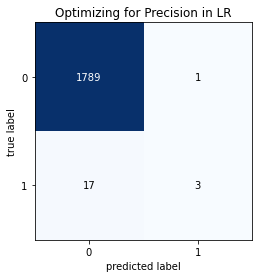

In [18]:
best_LR_model_precision.fit(X_train, y_train)
best_LR_pred = best_LR_model_precision.predict(X_test)
best_LR_cm_test = confusion_matrix(y_test, best_LR_pred)
fig, ax = plot_confusion_matrix(conf_mat=best_LR_cm_test)
plt.title('Optimizing for Precision in LR')
plt.show()

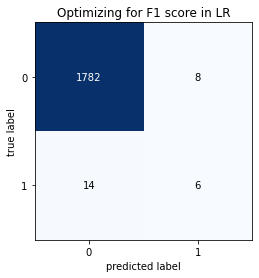

In [19]:
best_LR_model_F1.fit(X_train, y_train)
best_LR_pred = best_LR_model_F1.predict(X_test)
best_LR_cm_test = confusion_matrix(y_test, best_LR_pred)
fig, ax = plot_confusion_matrix(conf_mat=best_LR_cm_test)
plt.title('Optimizing for F1 score in LR')
plt.show()

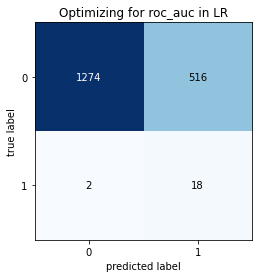

In [20]:
best_LR_model_auc.fit(X_train, y_train)
best_LR_pred = best_LR_model_auc.predict(X_test)
best_LR_cm_test = confusion_matrix(y_test, best_LR_pred)
fig, ax = plot_confusion_matrix(conf_mat=best_LR_cm_test)
plt.title('Optimizing for roc_auc in LR')
plt.show()

For now I will use F1 score (2 * (precision * recall) / (precision + recall)) for the following models

Now I will test the LinearSVC model, as SVC took too long to train

In [21]:
C = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

In [22]:
samplers = ['None', 'ros', 'rus']

In [23]:
hyperparameters = list(itertools.product(
                        C, samplers
))

hyperparameters

[(1, 'None'),
 (1, 'ros'),
 (1, 'rus'),
 (0.5, 'None'),
 (0.5, 'ros'),
 (0.5, 'rus'),
 (0.1, 'None'),
 (0.1, 'ros'),
 (0.1, 'rus'),
 (0.05, 'None'),
 (0.05, 'ros'),
 (0.05, 'rus'),
 (0.01, 'None'),
 (0.01, 'ros'),
 (0.01, 'rus'),
 (0.005, 'None'),
 (0.005, 'ros'),
 (0.005, 'rus'),
 (0.001, 'None'),
 (0.001, 'ros'),
 (0.001, 'rus')]

In [24]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
SVC_dict = {'SVC_C_value' : [],
            'Sampler': [],
            'F1_score_train': [],
            'F1_score_test': []}

run = 0
best_score_F1 = 0
best_SVC_model = None

for C_value, sampler_type in hyperparameters:

    # Counting what iteration I am on
    print(run)
    run += 1
    
    # Appending the parameters for this run to my dictionary
    SVC_dict['SVC_C_value'].append(C_value)
    SVC_dict['Sampler'].append(sampler_type)

    # Making pipelines for each sampler type, with the C value used within
    if sampler_type == 'rus':
        pipe = Pipeline(steps=[
            ('rus', RandomUnderSampler(random_state=21)),
            ('SVC', LinearSVC(C=C_value))
            ])

    elif sampler_type == 'ros':
        pipe = Pipeline(steps=[
            ('ros', RandomOverSampler(random_state=21)),
            ('SVC', LinearSVC(C=C_value))
            ])

    else:
        pipe = Pipeline(steps=[
            ('SVC', LinearSVC(class_weight={0:1, 1:99}, C=C_value))
            ])

    # Fitting the pipeline to the train set and predicting on both train and test sets
    pipe.fit(X_train, y_train)
    pipe_train_pred = pipe.predict(X_train)
    pipe_test_pred = pipe.predict(X_test)

    # Finding the roc_auc_score for both, I am including precision as in the past 
    # undersampling has led to awful precision scores
    F1_score_train = f1_score(y_train, pipe_train_pred)
    F1_score_test = f1_score(y_test, pipe_test_pred)

    # Appending the scores to the dictionary
    SVC_dict['F1_score_train'].append(F1_score_train)
    SVC_dict['F1_score_test'].append(F1_score_test)


    # Saving the best model
    if F1_score_test > best_score_F1:
        best_score_F1 = F1_score_test
        best_SVC_model = pipe

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [25]:
SVC_HPtable = pd.DataFrame.from_dict(SVC_dict) 
SVC_HPtable.sort_values(by='F1_score_test', ascending=False, inplace=True)
SVC_HPtable

,SVC_C_value,Sampler,F1_score_train,F1_score_test
13,0.010,ros,0.546296,0.241379
10,0.050,ros,0.825175,0.230769
12,0.010,None,0.470120,0.222222
9,0.050,None,0.813793,0.222222
16,0.005,ros,0.422939,0.202899
1,1.000,ros,1.000000,0.181818
0,1.000,None,1.000000,0.181818
4,0.500,ros,0.991597,0.181818
3,0.500,None,0.991597,0.181818
7,0.100,ros,0.914729,0.173913


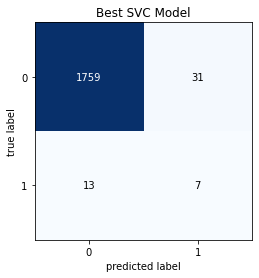

In [26]:
best_SVC_model.fit(X_train, y_train)
best_SVC_pred = best_SVC_model.predict(X_test)
best_SVC_cm_test = confusion_matrix(y_test, best_SVC_pred)
fig, ax = plot_confusion_matrix(conf_mat=best_SVC_cm_test)
plt.title('Best SVC Model')
plt.show()

Now a Random Forest Classifier

In [27]:
n_estimators = [int(n) for n in np.logspace(start=2, stop=3, num=5)]

In [28]:
samplers = ['None', 'ros', 'rus']

In [29]:
hyperparameters = list(itertools.product(
                        n_estimators, samplers
))

hyperparameters

[(100, 'None'),
 (100, 'ros'),
 (100, 'rus'),
 (177, 'None'),
 (177, 'ros'),
 (177, 'rus'),
 (316, 'None'),
 (316, 'ros'),
 (316, 'rus'),
 (562, 'None'),
 (562, 'ros'),
 (562, 'rus'),
 (1000, 'None'),
 (1000, 'ros'),
 (1000, 'rus')]

In [30]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
RFC_dict = {'n_estimators': [],
            'Sampler': [],
            'F1_score_train': [],
            'F1_score_test': []}

run = 0
best_score_F1 = 0
best_RFC_model = None

for n_estimator, sampler_type in hyperparameters:

    # Counting what iteration I am on
    print(run)
    run += 1
    
    # Appending the parameters for this run to my dictionary
    RFC_dict['Sampler'].append(sampler_type)
    RFC_dict['n_estimators'].append(n_estimator)

    # Making pipelines for each sampler type, with the n_estimator value used within
    if sampler_type == 'rus':
        pipe = Pipeline(steps=[
            ('rus', RandomUnderSampler(random_state=21)),
            ('RFC', RandomForestClassifier(n_estimators=n_estimator))
            ])

    elif sampler_type == 'ros':
        pipe = Pipeline(steps=[
            ('ros', RandomOverSampler(random_state=21)),
            ('RFC', RandomForestClassifier(n_estimators=n_estimator))
            ])

    else:
        pipe = Pipeline(steps=[
            ('RFC', RandomForestClassifier(n_estimators=n_estimator, class_weight="balanced_subsample"))
            ])

    # Fitting the pipeline to the train set and predicting on both train and test sets
    pipe.fit(X_train, y_train)
    pipe_train_pred = pipe.predict(X_train)
    pipe_test_pred = pipe.predict(X_test)

    # Finding the roc_auc_score for both, I am including precision as in the past 
    # undersampling has led to awful precision scores
    F1_score_train = f1_score(y_train, pipe_train_pred)
    F1_score_test = f1_score(y_test, pipe_test_pred)

    # Appending the scores to the dictionary
    RFC_dict['F1_score_train'].append(F1_score_train)
    RFC_dict['F1_score_test'].append(F1_score_test)


    # Saving the best model
    if F1_score_test > best_score_F1:
        best_score_F1 = F1_score_test
        best_RFC_model = pipe

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [31]:
RFC_HPtable = pd.DataFrame.from_dict(RFC_dict) 
RFC_HPtable.sort_values(by='F1_score_test', ascending=False, inplace=True)
RFC_HPtable

,n_estimators,Sampler,F1_score_train,F1_score_test
8,316,rus,0.121524,0.115016
11,562,rus,0.109972,0.109195
14,1000,rus,0.115686,0.108571
2,100,rus,0.108656,0.092545
5,177,rus,0.076973,0.062992
0,100,None,0.991453,0.000000
1,100,ros,1.000000,0.000000
3,177,None,1.000000,0.000000
4,177,ros,1.000000,0.000000
6,316,None,1.000000,0.000000


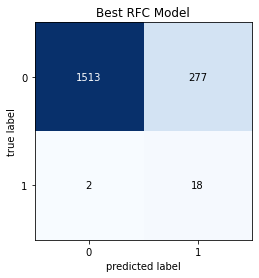

In [32]:
best_RFC_model.fit(X_train, y_train)
best_RFC_pred = best_RFC_model.predict(X_test)
best_RFC_cm_test = confusion_matrix(y_test, best_RFC_pred)
fig, ax = plot_confusion_matrix(conf_mat=best_RFC_cm_test)
plt.title('Best RFC Model')
plt.show()

**Trying truncatedSVD analysis on LR model**

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11, train_size=0.75, stratify=y)

This paper messed with the SVD analysis, having PCA1 and PCA2 scores 100s of times higher than the others. All I can see is that it is the longest paper by ~10x and contains a lot of newlines

In [142]:
X_train.iloc[4149]

Oral                                                            0
Poster                                                          1
Spotlight                                                       0
Unknown                                                         0
avg_word_len                                             4.553913
paper_len                                                  123727
paper_text      Learning Multiagent Communication\nwith Backpr...
title_len                                                      54
year                                                         2016
Name: 2789, dtype: object

In [143]:
new_df= df.sort_values(by='paper_len', ascending=False).head()
new_df

,year,paper_text,paper_id,title_len,paper_len,avg_word_len,Oral,Poster,Spotlight,Unknown,is_jordan
2789,2016,Learning Multiagent Communication\nwith Backpr...,6398,54,123727,4.553913,0,1,0,0,0
1564,2013,On the Representational Efficiency of Restrict...,5020,67,67731,4.215039,0,1,0,0,0
1566,2013,A Stability-based Validation Procedure for\nDi...,5014,82,61615,4.019754,0,1,0,0,0
5981,1987,317\n\nPARTITIONING OF SENSORY DATA BY A CORTI...,44,50,58011,5.471569,0,0,0,1,0
1781,2017,A Unified Game-Theoretic Approach to\nMultiage...,7007,70,56172,5.534487,0,1,0,0,0


In [144]:
tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(X_train.paper_text)
X_test = tfidf.transform(X_test.paper_text)

In [145]:
standard_scaler = StandardScaler(with_mean=False)

X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

In [146]:
tSVD = TruncatedSVD(n_components=2, random_state=21)

X_train = tSVD.fit_transform(X_train)
X_test = tSVD.transform(X_test)

In [147]:
PCAdf = pd.DataFrame(data=X_train, columns = ['PC1', 'PC2'])
y_df = pd.DataFrame(data=y_train, columns=['is_Jordan'])

PCAdf = pd.concat([PCAdf, y_df], axis = 1)
PCAdf.sort_values(by='is_Jordan', ascending=True, inplace=True)
PCAdf.drop(4149, inplace=True)

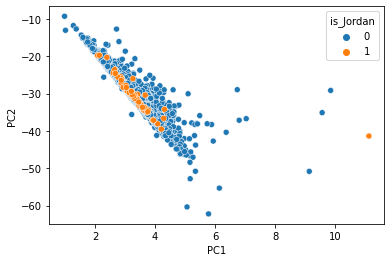

In [148]:
x_axis = PCAdf.PC1
y_axis = PCAdf.PC2

plt.subplots()
sns.scatterplot(x=x_axis, y=y_axis, hue=PCAdf.is_Jordan, data=PCAdf)
plt.show()

Seeing what TruncatedSVD does to the LR model

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11, train_size=0.75, stratify=y)

In [248]:
tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(X_train.paper_text)
X_test = tfidf.transform(X_test.paper_text)

In [249]:
standard_scaler = StandardScaler(with_mean=False)

X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

In [250]:
tSVD = TruncatedSVD(n_components=10, random_state=21)

X_train = tSVD.fit_transform(X_train)
X_test = tSVD.transform(X_test)

In [251]:
pipe = Pipeline(steps=[
            ('LR', LogisticRegression(class_weight={0:1, 1:99}, C=0.5))
            ])

In [252]:
pipe.fit(X_train, y_train)

pipe_train_pred = pipe.predict(X_train)
pipe_test_pred = pipe.predict(X_test)

In [253]:
F1_score_train = f1_score(y_train, pipe_train_pred)
F1_score_test = f1_score(y_test, pipe_test_pred)
print(F1_score_train)
print(F1_score_test)

0.025550421310138627
0.018166804293971925


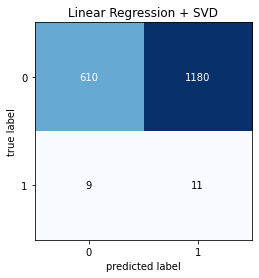

In [254]:
SVD_test = confusion_matrix(y_test, pipe_test_pred)
fig, ax = plot_confusion_matrix(conf_mat=SVD_test)
plt.title('Linear Regression + SVD')
plt.show()